In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
#import scvi
import numpy as np
import pandas as pd
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
data_dir = Path("/datasets/Tahoe-100M/Tahoe/vevo_filter/plate2_demo_final.h5ad")
adata = sc.read(data_dir)

In [3]:
adata

AnnData object with n_obs × n_vars = 83476 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'condition', 'dosage'

In [4]:
data_is_raw = True
n_hvg = 1200
sc.pp.highly_variable_genes(
    adata,
    layer=None,
    n_top_genes=1200,
    flavor="seurat_v3" if data_is_raw else "cell_ranger",
    subset=False,
)

In [5]:
drug_df = pd.read_csv("/datasets/Tahoe-100M/Tahoe/vevo_filter/plate2_demo_final_targets.csv")
drug_target_map = dict(zip(drug_df["compound"], drug_df["targets"]))

perturb_conditions = list(drug_target_map.values())
condition_names_gene = perturb_conditions

drug_target_map["ctrl"] = "ctrl"

In [6]:
len(condition_names_gene)

34

In [7]:
add_counter = 0
for g in condition_names_gene:
    if not adata.var.loc[adata.var[adata.var.index==g].index, 'highly_variable'].values[0]:
        adata.var.loc[adata.var[adata.var.index==g].index, 'highly_variable'] = True
        add_counter += 1

In [8]:
print('Manually add conditions: {}, {}'.format(add_counter, add_counter/len(condition_names_gene)))

Manually add conditions: 29, 0.8529411764705882


In [9]:
adata = adata[:, adata.var["highly_variable"]].copy()


In [10]:
adata

AnnData object with n_obs × n_vars = 83476 × 1229
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'condition', 'dosage'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [11]:
adata.obs["gene_target"] = adata.obs["condition"].map(drug_target_map)

In [12]:
adata.obs["gene_target"]

BARCODE_SUB_LIB_ID
08_003_169-lib_1000    TOP1
08_028_044-lib_1000    TOP1
08_046_119-lib_1000    TOP1
08_050_191-lib_1000    TOP1
08_064_086-lib_1000    TOP1
                       ... 
96_133_088-lib_999     ctrl
96_144_143-lib_999     ctrl
96_146_192-lib_999     ctrl
96_172_041-lib_999     ctrl
96_173_021-lib_999     ctrl
Name: gene_target, Length: 83476, dtype: object

In [13]:
adata

AnnData object with n_obs × n_vars = 83476 × 1229
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'condition', 'dosage', 'gene_target'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [14]:
from sklearn.metrics.pairwise import cosine_distances
from tqdm import tqdm
import pandas as pd

In [15]:
max_len = adata.shape[1] + 1
max_len

1230

In [16]:
adata.X[:5, :5].toarray()

array([[0., 4., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [17]:
sc.pp.log1p(adata)

In [18]:
# Wilcoxon rank
sc.tl.rank_genes_groups(adata, 'gene_target', method='wilcoxon', key_added = "wilcoxon", n_genes=max_len-1, reference='ctrl')
adata.uns['wilcoxon']['names']

/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/fs01/home/ahz/poetry_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is hi

rec.array([('FTL', 'PPP1R15A', 'FTL', 'HSP90AA1', 'FTL', 'PPP1R15A', 'NEAT1', 'FTL', 'MT2A', 'HSPA8', 'FTL', 'MT2A', 'FTH1', 'HSPA8', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'TXNRD1', 'FTL', 'MT2A', 'FTL', 'NEAT1', 'FTL', 'MT2A', 'PPP1R15A', 'MT2A', 'HSP90AA1', 'FTL', 'FTL', 'ARHGAP26'),
           ('PPP1R15A', 'NEAT1', 'MT2A', 'BIRC3', 'HSPA8', 'AKAP12', 'MALAT1', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'PPP1R15A', 'FTL', 'NEAT1', 'MYC', 'MT2A', 'FTL', 'FTL', 'WWC1', 'MT2A', 'FTL', 'MT2A', 'ARHGAP26', 'MT2A', 'FTL', 'HSPA8', 'FTL', 'HES1', 'MT2A', 'MT2A', 'PDE4D'),
           ('HES1', 'DDIT4', 'FTH1', 'PRKDC', 'TXNRD1', 'NEAT1', 'THSD4', 'HES1', 'MT1X', 'SOD2', 'KRT81', 'ADM', 'TXNRD1', 'BHLHE40', 'NUP58', 'HSPA8', 'MT2A', 'DDIT4', 'DDIT4', 'HSPA8', 'CYP1B1', 'HSP90AA1', 'KYNU', 'HSP90AA1', 'HES1', 'HSP90AA1', 'MT1X', 'NR3C1', 'UBC', 'HES1', 'KYNU'),
           ...,
           ('VCL', 'EFNA5', 'MALAT1', 'IGFBP3', 'IGFBP3', 'IARS1', 'IGSF11', 'HSPA5', 'VCL', 'EGR1', 'PDE4D', 'IGFBP3', 'EGR1', 'H

In [19]:
adata.uns['wilcoxon']

{'params': {'groupby': 'gene_target',
  'reference': 'ctrl',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('FTL', 'PPP1R15A', 'FTL', 'HSP90AA1', 'FTL', 'PPP1R15A', 'NEAT1', 'FTL', 'MT2A', 'HSPA8', 'FTL', 'MT2A', 'FTH1', 'HSPA8', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'TXNRD1', 'FTL', 'MT2A', 'FTL', 'NEAT1', 'FTL', 'MT2A', 'PPP1R15A', 'MT2A', 'HSP90AA1', 'FTL', 'FTL', 'ARHGAP26'),
            ('PPP1R15A', 'NEAT1', 'MT2A', 'BIRC3', 'HSPA8', 'AKAP12', 'MALAT1', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'PPP1R15A', 'FTL', 'NEAT1', 'MYC', 'MT2A', 'FTL', 'FTL', 'WWC1', 'MT2A', 'FTL', 'MT2A', 'ARHGAP26', 'MT2A', 'FTL', 'HSPA8', 'FTL', 'HES1', 'MT2A', 'MT2A', 'PDE4D'),
            ('HES1', 'DDIT4', 'FTH1', 'PRKDC', 'TXNRD1', 'NEAT1', 'THSD4', 'HES1', 'MT1X', 'SOD2', 'KRT81', 'ADM', 'TXNRD1', 'BHLHE40', 'NUP58', 'HSPA8', 'MT2A', 'DDIT4', 'DDIT4', 'HSPA8', 'CYP1B1', 'HSP90AA1', 'KYNU', 'HSP90AA1', 'HES1', 'HSP90AA1', 'MT1X', 'NR3C

In [21]:
import pickle

# Save to a pickle file
with open("wilcoxon_filtered.pkl", "wb") as f:
    pickle.dump(adata.uns["wilcoxon"], f)

In [22]:
adata.uns['wilcoxon']['names']

rec.array([('FTL', 'PPP1R15A', 'FTL', 'HSP90AA1', 'FTL', 'PPP1R15A', 'NEAT1', 'FTL', 'MT2A', 'HSPA8', 'FTL', 'MT2A', 'FTH1', 'HSPA8', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'TXNRD1', 'FTL', 'MT2A', 'FTL', 'NEAT1', 'FTL', 'MT2A', 'PPP1R15A', 'MT2A', 'HSP90AA1', 'FTL', 'FTL', 'ARHGAP26'),
           ('PPP1R15A', 'NEAT1', 'MT2A', 'BIRC3', 'HSPA8', 'AKAP12', 'MALAT1', 'MT2A', 'FTL', 'PPP1R15A', 'MT2A', 'PPP1R15A', 'FTL', 'NEAT1', 'MYC', 'MT2A', 'FTL', 'FTL', 'WWC1', 'MT2A', 'FTL', 'MT2A', 'ARHGAP26', 'MT2A', 'FTL', 'HSPA8', 'FTL', 'HES1', 'MT2A', 'MT2A', 'PDE4D'),
           ('HES1', 'DDIT4', 'FTH1', 'PRKDC', 'TXNRD1', 'NEAT1', 'THSD4', 'HES1', 'MT1X', 'SOD2', 'KRT81', 'ADM', 'TXNRD1', 'BHLHE40', 'NUP58', 'HSPA8', 'MT2A', 'DDIT4', 'DDIT4', 'HSPA8', 'CYP1B1', 'HSP90AA1', 'KYNU', 'HSP90AA1', 'HES1', 'HSP90AA1', 'MT1X', 'NR3C1', 'UBC', 'HES1', 'KYNU'),
           ...,
           ('VCL', 'EFNA5', 'MALAT1', 'IGFBP3', 'IGFBP3', 'IARS1', 'IGSF11', 'HSPA5', 'VCL', 'EGR1', 'PDE4D', 'IGFBP3', 'EGR1', 'H

In [23]:
baseline_rank = []

for c in perturb_conditions:
    # print(c)
    hvg_list = adata.uns['wilcoxon']['names'][c]
    p_val = adata.uns['wilcoxon']['pvals_adj'][c]
    df_gene_emb_dist = pd.DataFrame()
    df_gene_emb_dist['gene'] = hvg_list
    df_gene_emb_dist['p_val'] = p_val
    df_gene_emb_dist = df_gene_emb_dist.sort_values(by='p_val')
    print(c, np.where(df_gene_emb_dist.gene.values==c.split('+')[0])[0][0])
    baseline_rank.append(np.where(df_gene_emb_dist.gene.values==c.split('+')[0])[0][0])

EIF4E 330
GSK3B 37
PIK3CA 313
CYP19A1 770
PRKDC 519
MTOR 370
ATM 65
EPAS1 54
PSMB5 342
MET 212
PTGS2 33
ATR 200
MAPK7 490
PRKAA1 269
PBK 228
TOP1 63
PSMB5 342
RPS6KB1 171
NR3C1 107
PRKAA1 269
KLF5 56
EPHB4 594
MAP3K8 483
MAP4K4 19
MAPK14 268
RET 549
KRAS 146
MTOR 370
SMO 566
MAP2K1 42
AURKB 849
ERBB2 591
BRAF 125
BCL2 946


In [24]:
baseline_rank

[330,
 37,
 313,
 770,
 519,
 370,
 65,
 54,
 342,
 212,
 33,
 200,
 490,
 269,
 228,
 63,
 342,
 171,
 107,
 269,
 56,
 594,
 483,
 19,
 268,
 549,
 146,
 370,
 566,
 42,
 849,
 591,
 125,
 946]

In [25]:
with open("baseline_filtered.pkl", "wb") as f:
    pickle.dump(baseline_rank, f)

In [26]:
np.mean(baseline_rank)

317.29411764705884

Text(0, 0.5, 'Rank Value')

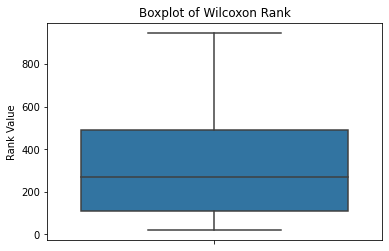

In [27]:
import seaborn as sns

sns.boxplot(y=baseline_rank)

# Add title and labels
plt.title("Boxplot of Wilcoxon Rank")
plt.ylabel("Rank Value")